In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

In [2]:

#Pull Data from LSV File Path
file_path = 'RD/baseline/0.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)

#Time Vector
t = df.iloc[:, 0].to_numpy()[:10000]
baseline = np.zeros((7, len(t)))
#Voltage Information
baseline[0] = df.iloc[:, 1].to_numpy()[-10000:]

file_path = 'RD/baseline/45.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[1] = df.iloc[:, 1].to_numpy()[-10000:]

file_path = 'RD/baseline/90.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[2] = df.iloc[:, 1].to_numpy()

file_path = 'RD/baseline/135.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[3] = df.iloc[:, 1].to_numpy()

file_path = 'RD/baseline/180.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[4] = df.iloc[:, 1].to_numpy()

file_path = 'RD/baseline/comfort.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[5] = df.iloc[:, 1].to_numpy()

file_path = 'RD/baseline/full.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)
baseline[6] = df.iloc[:, 1].to_numpy()

#dt and FS (time step and sampling frequency if needed, we used a FS of 1000 Hz I believe)
dt = t[1]-t[0]
FS = 1/dt

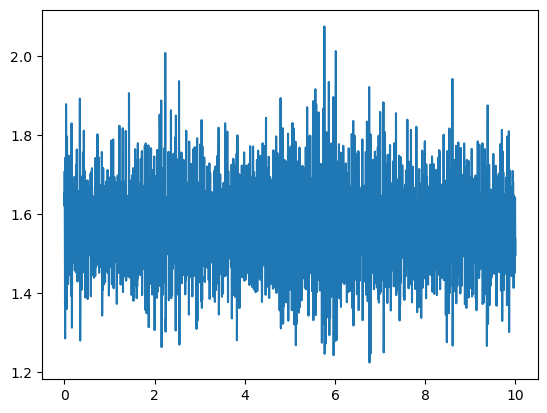

In [3]:
plt.plot(t, baseline[3])

In [4]:
def shift(voltage):
    return voltage - np.average(voltage)
average = np.zeros(len(baseline))
for i in range(len(baseline)):
    baseline[i] = shift(baseline[i])
    average[i] = np.mean(np.abs(baseline[i]))

In [5]:
def acq_Sim(array, acq_time_ms):
    chunk_size = int(acq_time_ms/dt/1000)
    """Split array into chunks of specified size."""
    num_chunks = len(array) // chunk_size + (1 if len(array) % chunk_size else 0)
    return [array[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

def process_acq_max(array_of_arrays):
    return np.array([np.max(np.abs(subarray)) for subarray in array_of_arrays])
def process_acq_mean(array_of_arrays):
    return np.array([np.mean(np.abs(subarray)) for subarray in array_of_arrays])
def process_acq_median(array_of_arrays):
    return np.array([np.median(np.abs(subarray)) for subarray in array_of_arrays])
t = df.iloc[:, 0].to_numpy()[:10000]

baseline_modified = process_acq_max(acq_Sim(baseline[2], 200))
baseline_modified_mean = process_acq_mean(acq_Sim(baseline[2], 200))
baseline_modified_median = process_acq_median(acq_Sim(baseline[2], 200))

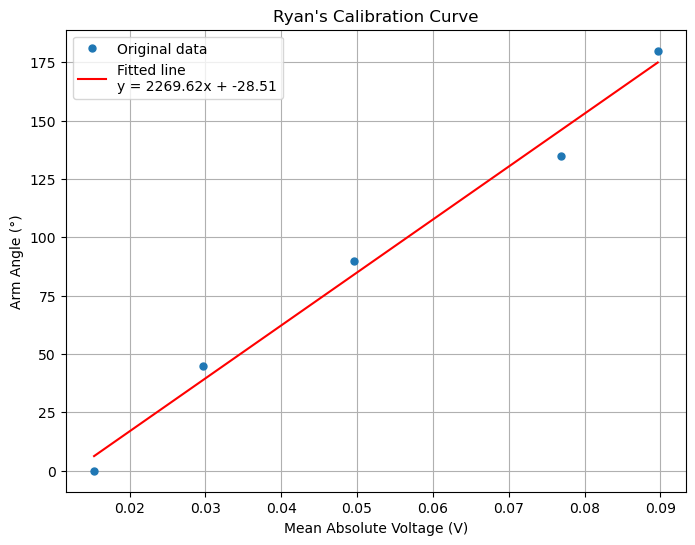

In [6]:
angles = np.arange(0, 181, 45)

slope, intercept, r_value, p_value, std_err = linregress(average[:-2], angles)

# Calculate the regression line values
regression_line = slope * average[:-2] + intercept

# Plot the original data and the regression line
plt.figure(figsize=(8, 6))
plt.plot(average[:-2], angles, 'o', label='Original data', markersize=5)  # Original data points
plt.plot(average[:-2], regression_line, 'r', label='Fitted line')  # Regression line
plt.grid()
plt.xlabel("Mean Absolute Voltage (V)")
plt.ylabel("Arm Angle (°)")
plt.title("Ryan's Calibration Curve")
equation_text = f"y = {slope:.2f}x + {intercept:.2f}"

plt.legend(['Original data', 'Fitted line\n' + equation_text])


(0.0, 0.2)

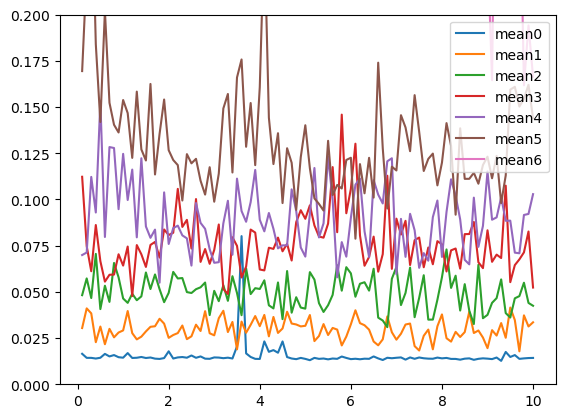

In [7]:
leng = 100
t_modified = process_acq_max(acq_Sim(t, leng))
baseline_acq = np.zeros((len(baseline),len(t_modified)))

for i in range(len(baseline)):
    
    baseline_acq[i] = process_acq_mean(acq_Sim(baseline[i], leng))
    plt.plot(t_modified, baseline_acq[i], label = 'mean' + str(i))

    plt.legend()
plt.ylim(0, 0.2)

In [8]:
def algorithm(voltage, acqtime_ms, average_duration_ms):
    values = np.zeros(len(voltage))
    numsamples = int(average_duration_ms/acqtime_ms)
    print(numsamples)
    pad = np.zeros(numsamples)
    paddedv = np.insert(voltage, 0, pad)
    for i in range(len(voltage)-numsamples):
        values[i] = np.sum(np.abs(paddedv[i:i+numsamples]))/numsamples
    return values

7
7
7
7
7
7
7


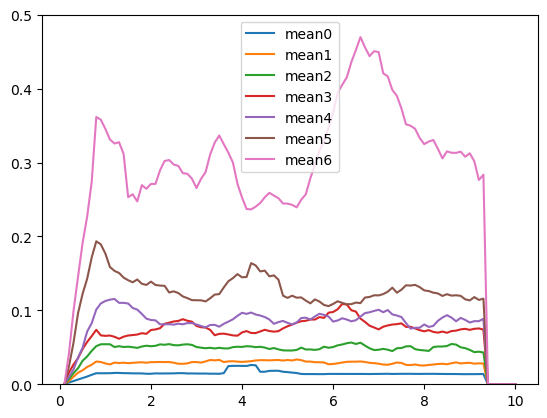

In [9]:

for i in range(len(baseline)):
    plt.plot(t_modified, algorithm(baseline_acq[i], 100, 700), label = 'mean' + str(i))
    plt.ylim(0, 0.5)
    plt.legend()


In [10]:
file_path = 'RD/motion/m1.lvm'
df = pd.read_csv(file_path, sep='\t', skiprows=23, header=None)

#Time Vector

#Voltage Information
voltage = df.iloc[:, 1].to_numpy()
voltage = shift(voltage)

4


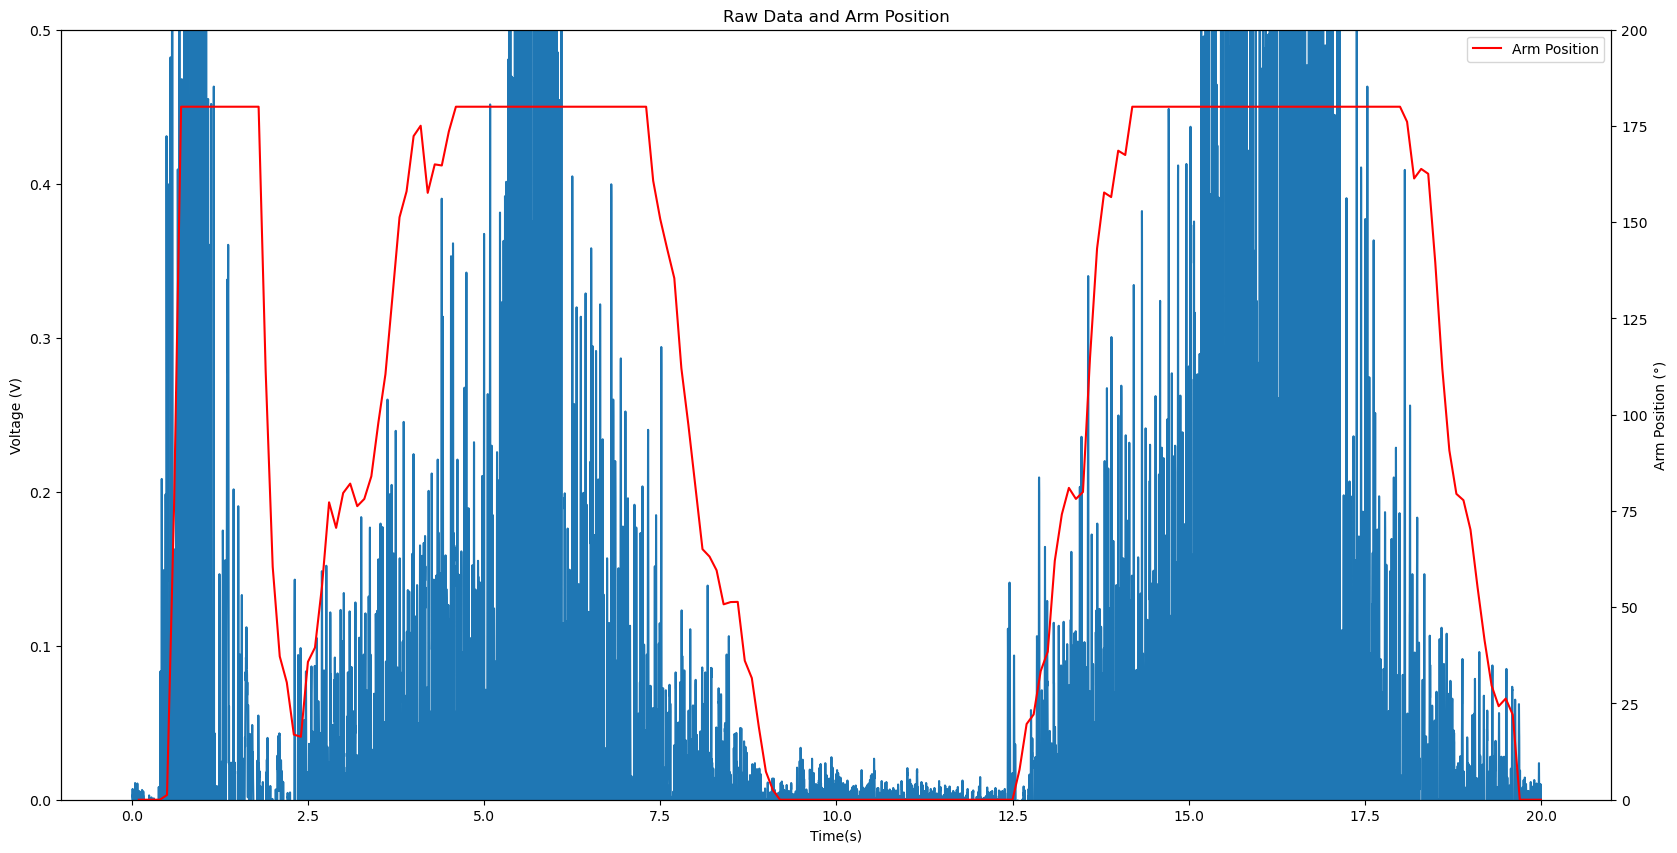

In [20]:

acq_time = 100
avg_time = 400
t_modified = process_acq_max(acq_Sim(t, acq_time))
v_processed = process_acq_mean(acq_Sim(voltage, acq_time))
v_processed = algorithm(v_processed, acq_time, avg_time)

predicted_y = slope * v_processed + intercept
# Clamp the predicted y values between 0 and 180

clamped_predicted_y = np.clip(predicted_y, 0, 180)


plt.figure(figsize=(20, 10))

# Plot raw data
plt.plot(t, voltage, label='Raw Data')
plt.ylim(0, 0.5)  # Set the limit for the primary y-axis
# Adding labels and title
plt.xlabel("Time(s)")
plt.ylabel("Voltage (V)")
# Create a secondary y-axis for the clamped_predicted_y
ax2 = plt.twinx()
ax2.plot(t_modified, clamped_predicted_y, label='Arm Position', color='r')
ax2.set_ylim(0, 200)  # Set the limit for the secondary y-axis to 0-180


ax2.set_ylabel("Arm Position (°)")

# Adding legends
plt.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Raw Data and Arm Position")
plt.show()
